* data download

In [ ]:
#%mkdir data
#%mkdir data/person

#!wget --no-check-certificate https://archive.ics.uci.edu/ml/machine-learning-databases/00196/ConfLongDemo_JSI.txt
#%mv ConfLongDemo_JSI.txt data/person/

### 1. Prepare analyze

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GraduateSchool/NeuralODE/midterm_assignment

Mounted at /content/drive
/content/drive/MyDrive/GraduateSchool/NeuralODE/midterm_assignment


In [ ]:
# Copyright 2021 The ODE-LSTM Authors. All Rights Reserved.
import os
import tensorflow as tf
import argparse
from irregular_sampled_datasets import PersonData
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = PersonData()

all_x.shape:  (9711, 32, 7)
all_t.shape:  (9711, 32, 1)
all_y.shape:  (9711, 32)
Total number of sequences: 9711
train_x.shape:  (7769, 32, 7)
train_t.shape:  (7769, 32, 1)
train_y.shape:  (7769, 32)
Total number of train sequences: 7769
Total number of test  sequences: 1942


### 2. Define RNN class
* * with time-dependent decay

In [ ]:
class RNNDecay(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units

        super(RNNDecay, self).__init__(**kwargs)

    def build(self, input_shape):
        self._layer = tf.keras.layers.Dense(self.units, activation="tanh")
        self._out_layer = tf.keras.layers.Dense(self.units, activation=None)
        self._tau = self.add_weight(
            name = "tau",
            shape=(self.units,),
            dtype=tf.float32,
            initializer=tf.keras.initializers.Constant(0.1),
        )
        self.built = True

    def call(self, inputs, states):
        #elapsed = 1.0 # 현재는 sequence 데이터를 사용할 것이라 하나만 넣는 경우가 없다.

        # person data의 크기가 (none, 8)이고 concat해서 time 정보를 마지막 column에 넣었기에 분리해준다.
        elapsed = inputs[:,7:]
        inputs = inputs[:,:-1]
        # if (isinstance(inputs, tuple) or isinstance(inputs, list)) and len(inputs) > 1:
        #     elapsed = inputs[-1]
        #     inputs = inputs[:-1]

        fused_input = tf.concat([inputs, states[0]], axis=-1)
        new_states = self._out_layer(self._layer(fused_input)) - elapsed * self._tau

        return new_states, [new_states]

In [ ]:
def train_model():
    pixel_input = tf.keras.Input(shape=(data.seq_len, data.feature_size), name="features")
    time_input = tf.keras.Input(shape=(data.seq_len, 1), name="time")

    # concatLayer 정의
    # 저자가 제공하는 lstm 코드에서는 call 부분에서 concat을 진행하였지만 현재 tensorflow rnn이 tuple 형태의 multi-input이 안되어 미리 병합하는 layer를 정의한다.
    class concatLayer(tf.keras.layers.Layer):
        def call(self, x, y):
            concat = tf.concat([x, y], axis=-1)  # (None, seq_len, feature_size + 1)
            return concat  # (None, seq_len, 8)

    # 입력 병합
    inputs = concatLayer()(pixel_input, time_input)

    # RNN 레이어 정의
    rnn = tf.keras.layers.RNN(RNNDecay(64), return_sequences=True)
    #rnn = VanillaRNN(VanillaRNN(64), return_sequences = True)
    dense_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(data.num_classes))

    # 입력 병합 및 모델 구성
    output_states = rnn(inputs)
    y = dense_layer(output_states)

    model = tf.keras.Model(inputs=[pixel_input, time_input], outputs=[y])
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    # 모델 훈련 및 평가
    hist = model.fit(
        x=(data.train_x, data.train_t),
        y=data.train_y,
        batch_size=128,
        epochs=200,
        validation_data=((data.test_x, data.test_t), data.test_y),
    )
    _, best_test_acc = model.evaluate(
        x=(data.test_x, data.test_t), y=data.test_y, verbose=2
    )

    return model, hist,best_test_acc

In [ ]:
model_1, hist_1, best_test_acc_1 = train_model()
print("1 끝")
model_2, hist_2, best_test_acc_2 = train_model()
print("2 끝")
model_3, hist_3, best_test_acc_3 = train_model()
print("3 끝")
model_4, hist_4, best_test_acc_4 = train_model()
print("4 끝")
model_5, hist_5, best_test_acc_5 = train_model()
print("5 끝")

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 2.1410 - sparse_categorical_accuracy: 0.2793 - val_loss: 1.6183 - val_sparse_categorical_accuracy: 0.3255
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6560 - sparse_categorical_accuracy: 0.3448 - val_loss: 1.5655 - val_sparse_categorical_accuracy: 0.3950
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5922 - sparse_categorical_accuracy: 0.4004 - val_loss: 1.4873 - val_sparse_categorical_accuracy: 0.4512
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4070 - sparse_categorical_accuracy: 0.4679 - val_loss: 1.1921 - val_sparse_categorical_accuracy: 0.5297
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2787 - sparse_categorical_accuracy: 0.5177 - val_loss: 1.0332 - val_sparse_categorical_accuracy: 0.5985
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1400 - sparse_categorical_accuracy: 0.5558 - val_loss: 0.9444 - val_sparse_categorical_accuracy: 0.6478
Epoch 7/

In [ ]:
def plot_hist(hist):
    # history에서 loss, accuracy 값 추출
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    sparse_categorical_accuracy = hist.history['sparse_categorical_accuracy']
    val_sparse_categorical_accuracy = hist.history['val_sparse_categorical_accuracy']

    epochs = range(1, len(loss) + 1)

    # Loss 그래프
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, sparse_categorical_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_sparse_categorical_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

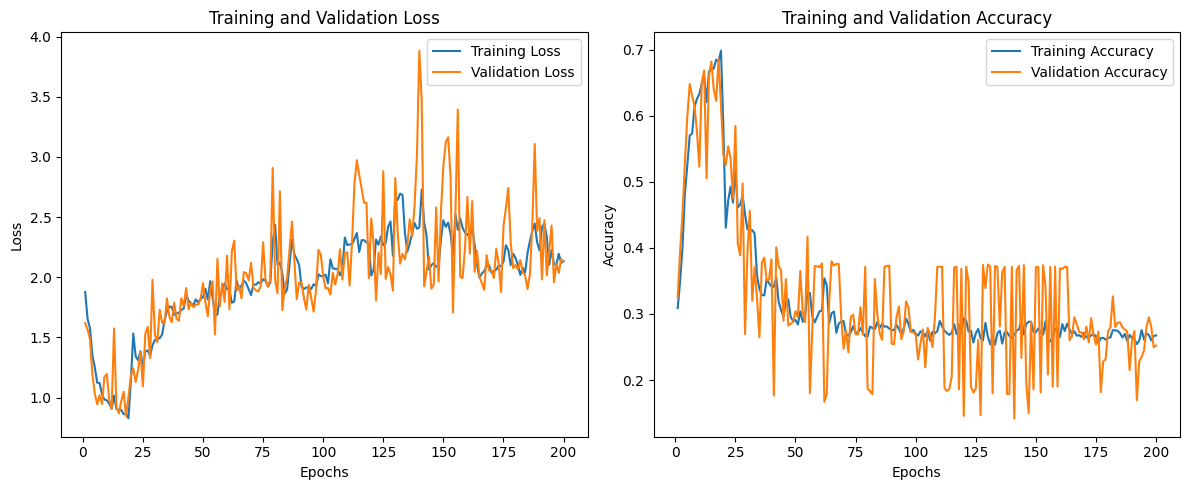

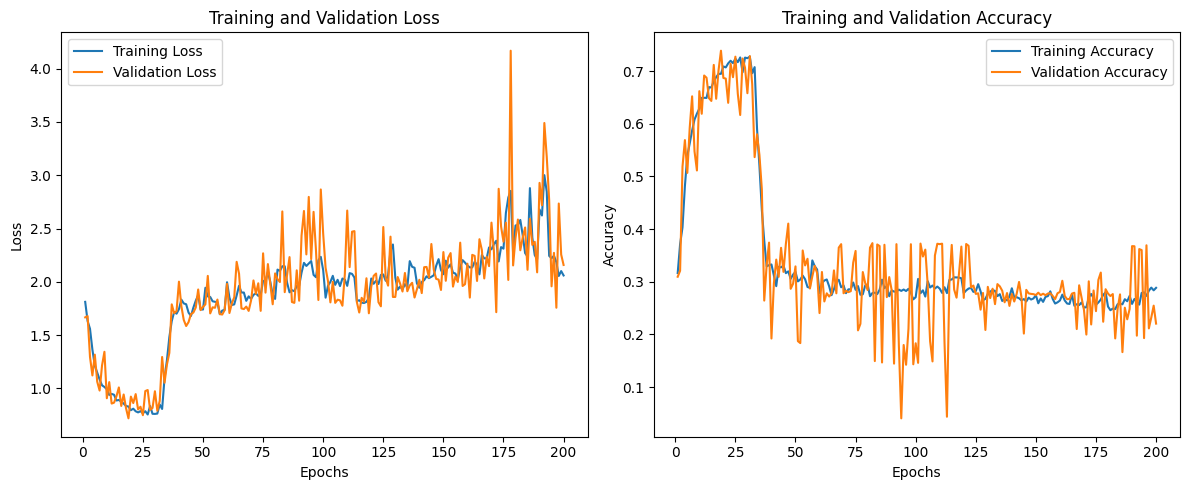

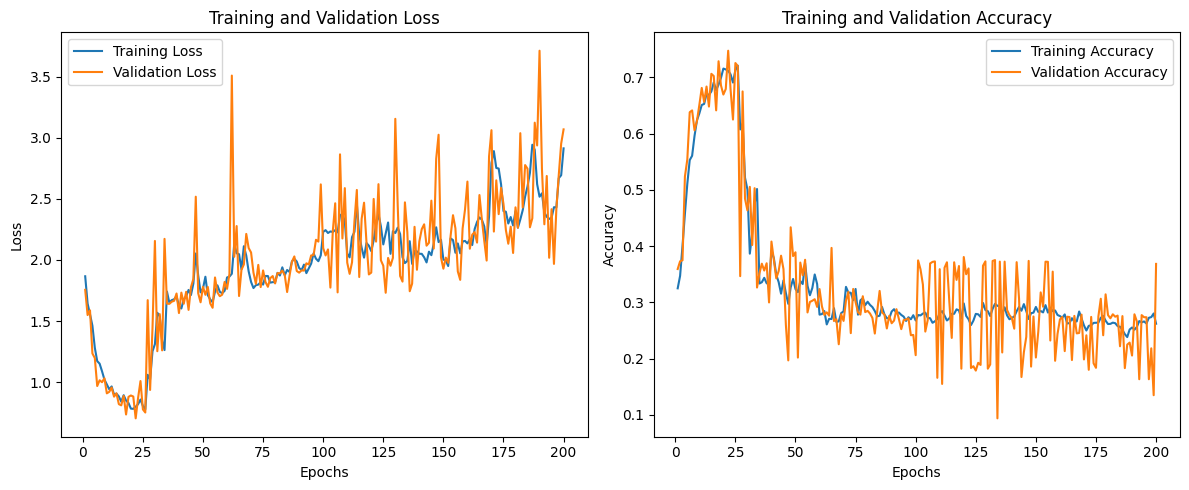

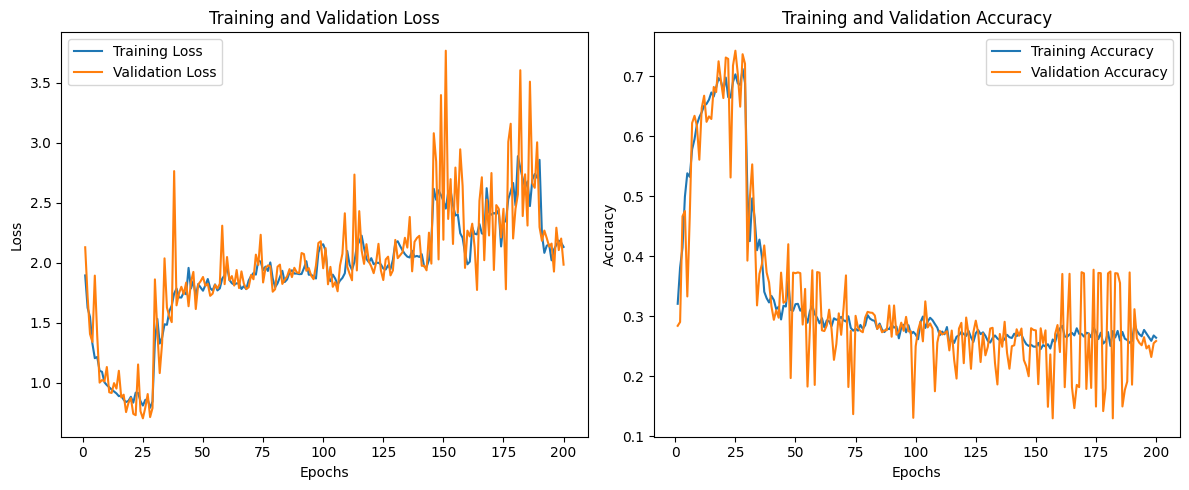

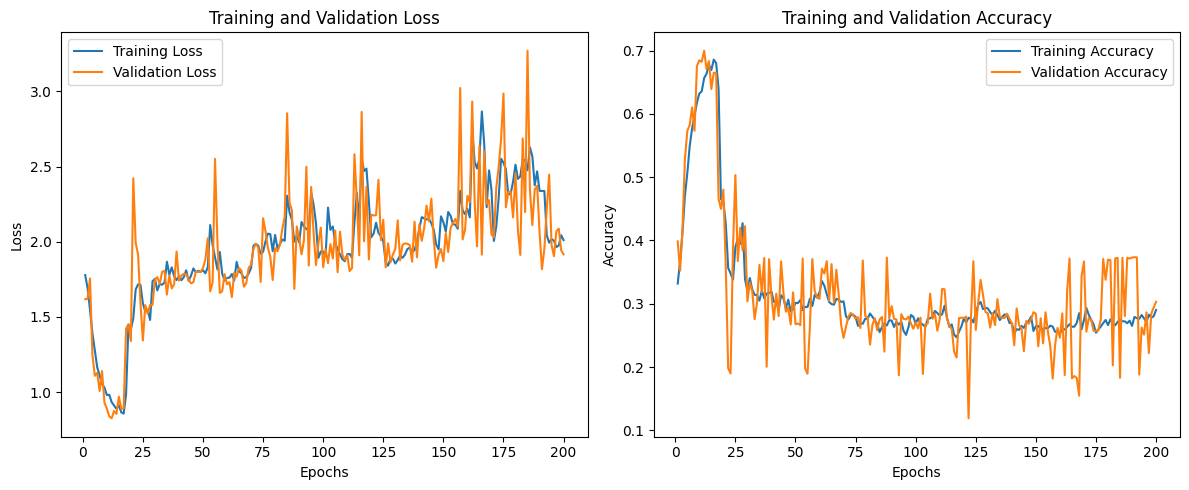

In [ ]:
plot_hist(hist_1)
plot_hist(hist_2)
plot_hist(hist_3)
plot_hist(hist_4)
plot_hist(hist_5)

In [ ]:
mean = np.mean([best_test_acc_1,  best_test_acc_2, best_test_acc_3, best_test_acc_4, best_test_acc_5])
std = np.std([best_test_acc_1,  best_test_acc_2, best_test_acc_3, best_test_acc_4, best_test_acc_5])

print(f"{mean*100}%, {std*100}")

28.063530027866364%, 5.121746396363867


* RNN decay - 0.6857, 0.7389, 0.7474, 0.7428, 0.6999 를 best test accuarcy로 찾아 넣었다.